In [28]:
%pylab inline
from pyMouSh import MoulinShape, TimeStamps, Qin_constant, Qin_sinusoidal, Qin_real, calculate_h_S_schoof, find_nearest
import numpy as np
from datetime import datetime as dt  
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch
import pandas as pd
import pickle
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


C:\Users\celia\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['time', 'xlim', 'outer', 'figure', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [29]:
secinday = 24*3600
ZERO_KELVIN = 273.15
#paramters

#temperature profile based of foxx data -- Lauren
tmp = pd.read_csv('Field_Data/temperature_foxx1.csv')
temperature_profile = tmp.temperature.to_numpy()#np.array([ZERO_KELVIN, ZERO_KELVIN])

moulin_radii = 0.2
initial_subglacial_area = 1 
regional_surface_slope = 0.01
channel_length = 25e3
ice_thickness = 500
initial_head = ice_thickness

#import JEME dye
dye = pd.read_csv('Field_Data/JEME_Qdye.csv', index_col=0, parse_dates=True)
elapsed = dye.index-dt(2017, 1, 1,00,00,00)
dye['SOY']=elapsed.total_seconds()
dye['DOY']=dye.SOY/3600/24  
Qdye = dye['Discharge (m^3/s)'].to_numpy()
dye_soy = dye.SOY.to_numpy()
dye_doy = dye.DOY.to_numpy()

#Import meltwater input calculated with meltmodel for JEME
drainage_basin = 0.9e6 #in m^2
meltmodel = pd.read_csv('Field_Data/jeme_hourly_melt_and_qsuh.csv')
meltmodel = meltmodel.dropna()
melt = meltmodel.melt_mmperh_smooth_6h.to_numpy()# mm/h
Qmelt = (melt/1e3/3600) * drainage_basin
qsuh = meltmodel.q_suh_mmh #mm/h
Qsuh = (qsuh/1e3/3600) * drainage_basin
meltmodel_soy = meltmodel.SOY.to_numpy() #add routing delay -- Jess found 2h not 4. investigate why
meltmodel_doy = meltmodel.DOY.to_numpy()

#Import head measurement for JEME
jeme_moulin = pd.read_csv('Field_Data/head_jeme.csv')
jeme_moulin = jeme_moulin.dropna()
h_real = jeme_moulin.head_bed.to_numpy()
h_soy = jeme_moulin.soy.to_numpy()
h_doy = h_soy/secinday

#set timeserie length and timestep for interpolation
time_start = meltmodel_soy[int(2*secinday/900)]  
time_end = time_start + 65*secinday
timestep = 10*60#300 #seconds to reduce number of saved data
time = TimeStamps(time_start,time_end,timestep)

#calculate meltwater input (interpolate)
meltwater_input = Qin_real(time, Qsuh+0.01, meltmodel_soy)

#calculate baseflow
bf_mean = 0.5
bf_amp = 0.05 
shift0h = 0.42 * secinday
shift12h = 0 * secinday # sin is already shifted from input
baseflow_shift0 = Qin_sinusoidal(time,bf_mean, bf_amp, shift=shift0h)
baseflow_shift12 = Qin_sinusoidal(time,bf_mean, bf_amp, shift=shift12h)



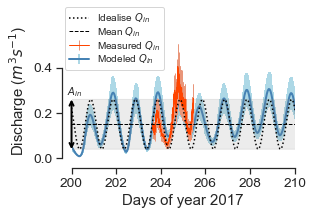

In [30]:
figure, (ax) = plt.subplots(1,1, sharey=True, figsize=(4,2.5))

mean = 0.15
App = 0.22
A_in_star = App/mean

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

xfit = meltmodel_doy
#yfit = smooth(Qsuh,20)
yfit = np.ones(len(meltmodel_doy))*mean

sin_melt_input = Qin_sinusoidal(meltmodel_soy, mean, App/2, 15)


ax.fill_between(xfit, yfit - 0.11, yfit+ 0.11, color='gray', alpha=0.15)
#ax.fill_between(xfit, yfit - 0.06, yfit+ 0.06, color='gray', alpha=0.15)
ax.errorbar(dye_doy,Qdye,yerr=Qdye*0.25, 
            label='Measured $Q_{in}$', color = 'orangered', linewidth=1, ecolor='darksalmon',zorder=1)
ax.errorbar(meltmodel_doy, Qsuh, yerr=Qsuh*0.25, 
            color='steelblue', label='Modeled $Q_{in}$',linewidth=2, ecolor='lightblue',zorder=0)
ax.plot(meltmodel_doy,sin_melt_input,linestyle=':',color='black', label='Idealise $Q_{in}$',zorder=2)
ax.plot(xfit,yfit, color='black', linewidth=1, linestyle='--', label='Mean $Q_{in}$',zorder=3)

ax.add_artist(ConnectionPatch((200,mean-App/2),(200,mean+App/2),'data','data', shrinkB=0,
                arrowstyle="<->", color='black', linewidth=2,zorder=4))
ax.text(199.8,0.28,'$A_{in}$',fontsize=10)

ax.set_ylabel('Discharge ($m^3s^{-1}$)')
ax.set_xlabel('Days of year 2017')
ax.legend(loc=2,labelspacing=0,bbox_to_anchor=(-0.05, 1.15), prop={'size': 10})
ax.set_xlim(200,210)
ax.set_ylim(0,0.6)

sns.despine(offset=10,trim=True)

plt.savefig('stream_discharge.pdf',bbox_inches = 'tight')

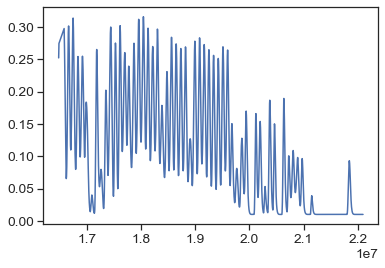

In [31]:
plt.plot(time,meltwater_input)

In [32]:
def plot_data(moulin_sim,h_doy,h_real,idx=-1,
             Q_lim=[0,0.5], radius_lim=[0,1]):
    
    fig = plt.figure(figsize=(13,5))   
    grid = plt.GridSpec(4,3)#, wspace=-0.7)
    
    ax1b = fig.add_subplot(grid[0, 0:2])#Qin
    ax1a = ax1b.twinx()
    ax2 = fig.add_subplot(grid[1:4, 2])#moulin
    ax3 = fig.add_subplot(grid[1:4, 0:2])#hw
    ax4 = fig.add_subplot(grid[3, 0:2])#SCs  

    ax1a.yaxis.set_label_coords(1.15, 0.7)
    ax1b.yaxis.set_label_coords(-0.065, 0.5)
    ax3.yaxis.set_label_coords(-0.08, 0.7)
    ax4.yaxis.set_label_coords(-0.08, 0.5)
    
    ground_depth=-60
    spine_head_min=200
    lw=1.5
    
    #baseflow
    moulin_sim.plot_baseflow(ax1a,
                       color='seagreen',
                       bottom_axis=False,
                       axis_side = 'right') 
    #ax1a.set_xlim(t_lim) 

    #Meltwater
    moulin_sim.plot_Qin(ax1b,
                   bottom_axis=False,
                   axis_side = 'left',
                   color='grey') 
    #ax1b.set_xlim(t_lim) 
    ax1b.set_ylim(Q_lim)


    #Moulin
    moulin_sim.plot_moulin(ax2,idx,
                     left_lim = -5,
                     left_bound = -4,
                     right_lim = 5,
                     right_bound = 4,
                     x_tick_spacing = 2,
                     ground_depth=ground_depth,
                     axis_side = 'right',)

    #Head
    ax3.plot(h_doy,h_real,'-',color='black') 
    moulin_sim.plot_head(ax3,
                   color='steelblue',
                   spine_head_min = spine_head_min,
                   bottom_axis = False,
                   axis_side = 'left',
                   ground_depth = ground_depth) 

    #ax3.set_xlim(t_lim)


    #Subglacial radius
    moulin_sim.plot_subglacial_radius(ax4,
                               color='orangered',
                               bottom_axis=True,
                               axis_side = 'left')         
    #ax4.set_xlim(t_lim)
    #ax4.tick_params(axis='x',labelsize=8)
    ax4.set_ylim(radius_lim)
    #ax4.spines['bottom'].set_bounds(t_lim[0]+0.1,t_lim[1])
    ax4.set_xlabel('Days')


    #Legend 
    size_legend=10
    l1a = ax1a.legend(['Subglacial baseflow'],
                      loc="upper left", bbox_to_anchor=(0.7, 1.1), prop={'size': size_legend})  
    for line, text in zip(l1a.get_lines(), l1a.get_texts()):
        text.set_color(line.get_color())  
    l1b = ax1b.legend(['Meltwater input'],
                      loc="upper left", bbox_to_anchor=(0, 1.1), prop={'size': size_legend})
    for line, text in zip(l1b.get_lines(), l1b.get_texts()):
        text.set_color(line.get_color())  
    l3 = ax3.legend(['Head measured','Head simulated'],
                    loc="upper left", bbox_to_anchor=(0, 1), prop={'size': size_legend})    
    for line, text in zip(l3.get_lines(), l3.get_texts()):
        text.set_color(line.get_color())
    l4 = ax4.legend(['Subglacial radius'],
                    loc="upper left", bbox_to_anchor=(0, 1.1), prop={'size': size_legend})
    for line, text in zip(l4.get_lines(), l4.get_texts()):
        text.set_color(line.get_color())
    ax4.patch.set_alpha(0)

    #thicker axis
    for axis in ['top','bottom','left','right']:
        ax1a.spines[axis].set_linewidth(lw)
    ax1a.tick_params(width=lw)
    
    for axis in ['top','bottom','left','right']:
        ax1b.spines[axis].set_linewidth(lw)
    ax1b.tick_params(width=lw)

    for axis in ['top','bottom','left','right']:
        ax2.spines[axis].set_linewidth(lw)
    ax2.tick_params(width=lw)

    for axis in ['top','bottom','left','right']:
        ax3.spines[axis].set_linewidth(lw)
    ax3.tick_params(width=lw)

    for axis in ['top','bottom','left','right']:
        ax4.spines[axis].set_linewidth(lw)
    ax4.tick_params(width=lw)
        




   

# Calculate timeseries
Run those next cells only if you want to change a parameter. 
otherwise, go to -- Plot ---

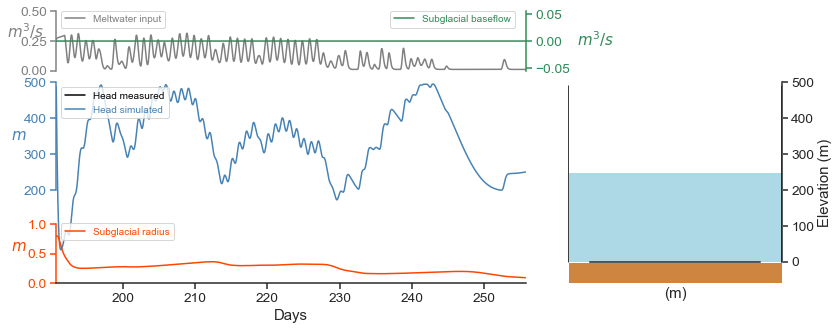

In [33]:
cylinder10 = MoulinShape(moulin_radii = 5.,
                      ice_thickness = ice_thickness,
                      initial_head = initial_head,
                      initial_subglacial_area = initial_subglacial_area,
                      channel_length = channel_length,
                      regional_surface_slope = regional_surface_slope,
                      temperature_profile = temperature_profile)

for idx,t in enumerate(time) :
    cylinder10.run1step(t,
                    timestep,
                    meltwater_input[idx],
                    creep=False,
                    elastic_deformation=False,
                    melt_below_head=False,
                    open_channel_melt=False,
                    potential_drop=False,
                    ice_motion=False,
                    refreezing=False)
    
plot_data(cylinder10,h_soy,h_real)
plt.savefig('cylinder10.pdf')

picklefile = open('cylinder10_TC', 'wb')
pickle.dump(cylinder10, picklefile)
picklefile.close()

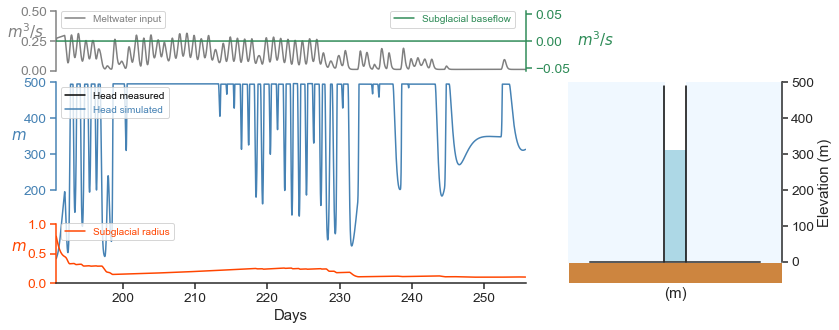

In [34]:
cylinder1 = MoulinShape(moulin_radii = 0.5,
                      ice_thickness = ice_thickness,
                      initial_head = initial_head,
                      initial_subglacial_area = initial_subglacial_area,
                      channel_length = channel_length,
                      regional_surface_slope = regional_surface_slope,
                      temperature_profile = temperature_profile)

for idx,t in enumerate(time) :
    cylinder1.run1step(t,
                    timestep,
                    meltwater_input[idx],
                    creep=False,
                    elastic_deformation=False,
                    melt_below_head=False,
                    open_channel_melt=False,
                    potential_drop=False,
                    ice_motion=False,
                    refreezing=False)
    
plot_data(cylinder1,h_soy,h_real)
plt.savefig('cylinder1.pdf')

picklefile = open('cylinder1_TC', 'wb')
pickle.dump(cylinder1, picklefile)
picklefile.close()

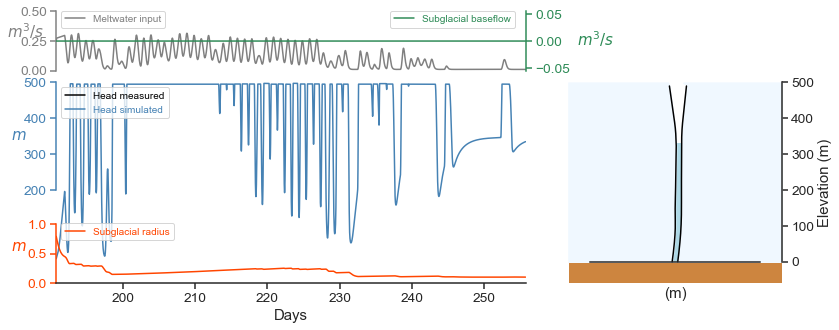

In [35]:
bf0_fix = MoulinShape(moulin_radii = moulin_radii,
                      ice_thickness = ice_thickness,
                      initial_head = initial_head,
                      initial_subglacial_area = initial_subglacial_area,
                      channel_length = channel_length,
                      regional_surface_slope = regional_surface_slope,
                      temperature_profile = temperature_profile)

for idx,t in enumerate(time) :
    bf0_fix.run1step(t,
                    timestep,
                    meltwater_input[idx],
                    subglacial_baseflow = 0)
    
plot_data(bf0_fix,h_soy,h_real)
plt.savefig('bf0_fix.pdf')

picklefile = open('bf0_fix_TC', 'wb')
pickle.dump(bf0_fix, picklefile)
picklefile.close()

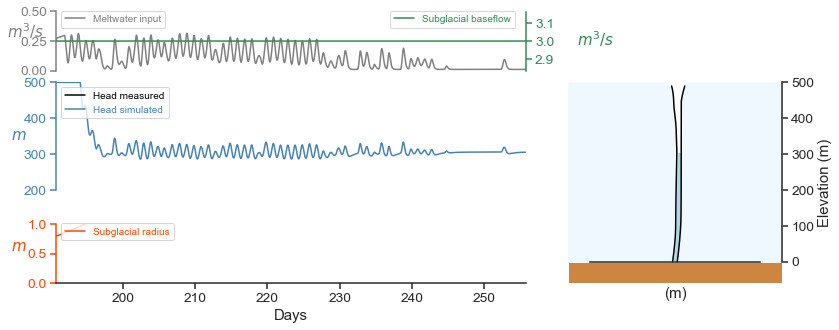

In [37]:
bf3_fix = MoulinShape(moulin_radii = moulin_radii,
                      ice_thickness = ice_thickness,
                      initial_head = initial_head,
                      initial_subglacial_area = initial_subglacial_area,
                      channel_length = channel_length,
                      regional_surface_slope = regional_surface_slope,
                      temperature_profile = temperature_profile)

for idx,t in enumerate(time) :
    bf3_fix.run1step(t,
                    timestep,
                    meltwater_input[idx],
                    subglacial_baseflow = 3)
    
    
plot_data(bf3_fix,h_soy,h_real)
plt.savefig('bf3_fix.pdf')

picklefile = open('bf3_fix_TC', 'wb')
pickle.dump(bf3_fix, picklefile)
picklefile.close()

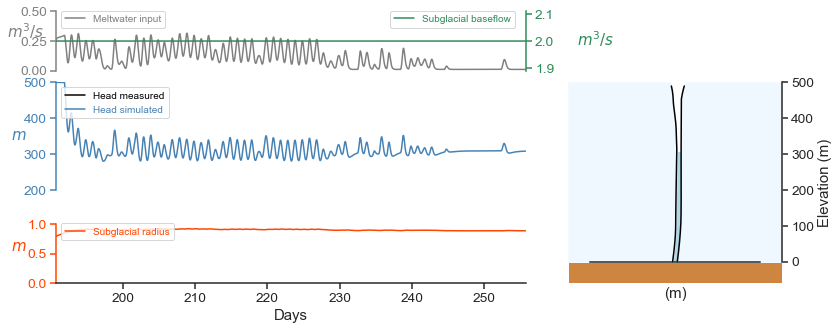

In [38]:
bf2_fix = MoulinShape(moulin_radii = moulin_radii,
                      ice_thickness = ice_thickness,
                      initial_head = initial_head,
                      initial_subglacial_area = initial_subglacial_area,
                      channel_length = channel_length,
                      regional_surface_slope = regional_surface_slope,
                      temperature_profile = temperature_profile)

for idx,t in enumerate(time) :
    bf2_fix.run1step(t,
                    timestep,
                    meltwater_input[idx],
                    subglacial_baseflow = 2)
    
    
plot_data(bf2_fix,h_soy,h_real)
plt.savefig('bf2_fix.pdf')

picklefile = open('bf2_fix_TC', 'wb')
pickle.dump(bf2_fix, picklefile)
picklefile.close()

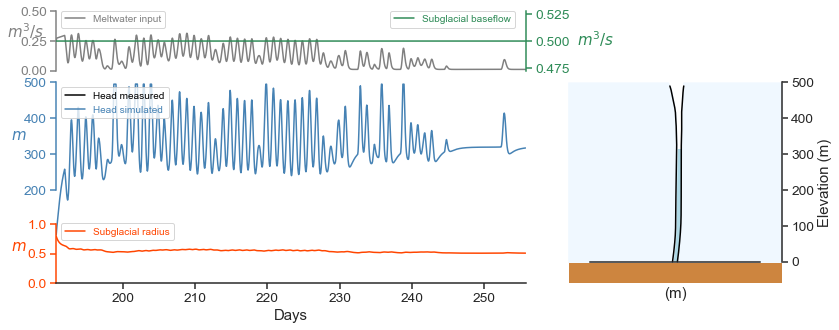

In [49]:
bf1_fix = MoulinShape(moulin_radii = moulin_radii,
                      ice_thickness = ice_thickness,
                      initial_head = initial_head,
                      initial_subglacial_area = initial_subglacial_area,
                      channel_length = channel_length,
                      regional_surface_slope = regional_surface_slope,
                      temperature_profile = temperature_profile)

for idx,t in enumerate(time) :
    bf1_fix.run1step(t,
                    timestep,
                    meltwater_input[idx],
                    subglacial_baseflow = bf_mean)
    
plot_data(bf1_fix,h_soy,h_real)
plt.savefig('bf1_fix.pdf')

picklefile = open('bf1_fix_TC', 'wb')
pickle.dump(bf1_fix, picklefile)
picklefile.close()

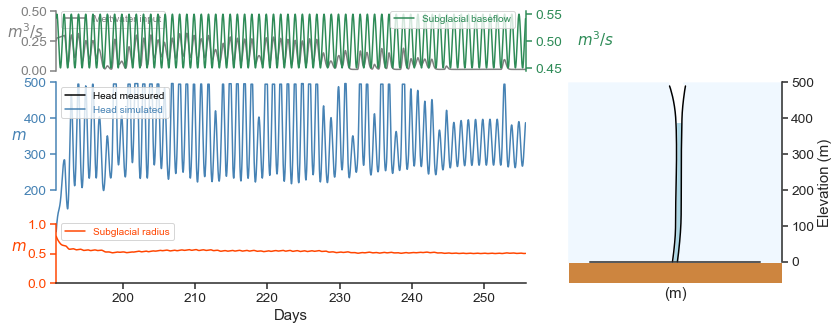

In [39]:
bf1_osc = MoulinShape(moulin_radii = moulin_radii,
                      ice_thickness = ice_thickness,
                      initial_head = initial_head,
                      initial_subglacial_area = initial_subglacial_area,
                      channel_length = channel_length,
                      regional_surface_slope = regional_surface_slope,
                      temperature_profile = temperature_profile)

for idx,t in enumerate(time) :
    bf1_osc.run1step(t,
                    timestep,
                    meltwater_input[idx],
                    subglacial_baseflow = baseflow_shift0[idx])
    
    
plot_data(bf1_osc,h_soy,h_real)
plt.savefig('bf1_osc.pdf')

picklefile = open('bf1_osc_TC', 'wb')
pickle.dump(bf1_osc, picklefile)
picklefile.close()

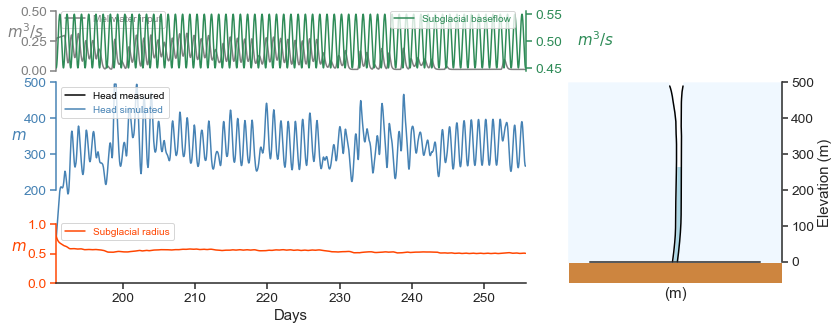

In [40]:
bf1_osc_shift = MoulinShape(moulin_radii = moulin_radii,
                      ice_thickness = ice_thickness,
                      initial_head = initial_head,
                      initial_subglacial_area = initial_subglacial_area,
                      channel_length = channel_length,
                      regional_surface_slope = regional_surface_slope,
                      temperature_profile = temperature_profile)

for idx,t in enumerate(time) :
    bf1_osc_shift.run1step(t,
                    timestep,
                    meltwater_input[idx],
                    subglacial_baseflow = baseflow_shift12[idx])
    
plot_data(bf1_osc_shift,h_soy,h_real)
plt.savefig('bf1_osc_shift.pdf')

picklefile = open('bf1_osc_shift_TC', 'wb')
pickle.dump(bf1_osc_shift, picklefile)
picklefile.close()

# Plot data
Use pickled data if possible

In [41]:

picklefile = open('cylinder10_TC', 'rb')
cylinder10 = pickle.load(picklefile)
picklefile.close()

picklefile = open('cylinder1_TC', 'rb')
cylinder1 = pickle.load(picklefile)
picklefile.close()

picklefile = open('bf0_fix_TC', 'rb')
bf0_fix = pickle.load(picklefile)
picklefile.close()

picklefile = open('bf1_fix_TC', 'rb')
bf1_fix = pickle.load(picklefile)
picklefile.close()

picklefile = open('bf3_fix_TC', 'rb')
bf3_fix = pickle.load(picklefile)
picklefile.close()

picklefile = open('bf2_fix_TC', 'rb')
bf2_fix = pickle.load(picklefile)
picklefile.close()

picklefile = open('bf1_osc_TC', 'rb')
bf1_osc = pickle.load(picklefile)
picklefile.close()

picklefile = open('bf1_osc_shift_TC', 'rb')
bf1_osc_shift = pickle.load(picklefile)
picklefile.close()


self.dict['meltwater_input_moulin']\
self.dict['melwater_input_compensated_moulin']\
self.dict['meltwater_output_subglacial']\
self.dict['subglacial_cross_section_area']\
self.dict['subglacial_radius']\
self.dict['head']\
self.dict['subglacial_baseflow']\
self.dict['head_L']\
self.dict['all_idx']\
self.dict['time']\
self.time_day

# Plot fig 02

In [42]:
def plot_moulin(sim, ax, day, lim=5, yaxis=True,xaxis=False, watercolor='lightblue'):
    
    idx=sim.dict['time'].index(find_nearest(sim.dict['time'], day*secinday))
    Mx_upstream = sim.listdict[idx]['moulin_wall_position_upstream']
    Mx_downstream = sim.listdict[idx]['moulin_wall_position_downstream']   
    
    ax.plot(Mx_upstream[0:-10],sim.z[0:-10],color='black') #plot major axis on the left
    ax.plot(Mx_downstream[0:-10],sim.z[0:-10],color='black')  #plot minor axis on the right

    #sns.lineplot(x=Mx_upstream[0:-10],y=sim.z[0:-10],color='black',ax=ax) #plot major axis on the left
    #sns.lineplot(x=Mx_downstream[0:-10],y=sim.z[0:-10],color='black',ax=ax)  #plot minor axis on the right

    ax.axhspan(0, sim.dict['head'][idx], facecolor = watercolor, alpha = 1,zorder=1)    
    ax.fill_betweenx(sim.z,-lim,Mx_upstream,color='aliceblue',zorder=2)
    ax.fill_betweenx(sim.z,Mx_downstream,lim,color='aliceblue',zorder=2) 
    ax.axhspan(-60, 0, facecolor ='peru', alpha = 1,zorder=1)
    ax.set_xlim([-lim,lim]) 
    ax.set_ylim([-60,sim.ice_thickness])    
    ax.spines['bottom'].set_position(('zero')) 
    
    if xaxis==False:
        ax.spines['bottom'].set_visible(True)
        ax.tick_params(bottom=False, labelbottom=False)       
    
    if yaxis==True:
        ax.set_ylabel('z (m)')   
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')         
    else:
        ax.tick_params(left=False, labelleft=False)
          
#fig,ax = subplots()
#plot_moulin(bf3_fix,ax,200,lim=5,yaxis=False)
#plt.savefig('moulin.pdf')



def plot_timeserie(sim, ax, variable, ylim, ylabel='ylabel', xlabel=False, xlim=[200,240], color='red'):
    sns.lineplot(x=sim.time_day,y=sim.dict[variable],ax=ax,color=color, alpha=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel, color=color)
    sns.despine(ax=ax,trim=True, offset=[10,10])
    ax.spines['left'].set_color(color)
    ax.tick_params(axis='y', colors=color)
    ax.patch.set_alpha(0)
    
    if xlabel == True:
        ax.set_xlabel('Day of year 2017')
    else:
        ax.spines['bottom'].set_visible(False) 
        ax.tick_params(bottom=False, labelbottom=False)
        
#fig,ax = subplots()
#plot_timeserie(bf3_fix,ax,'head', ylabel='label', ylim=[166,500], xlim=[190,250])


def plot_number(ax,string,x,y):
    ax.text(x,y,string, fontsize=12,bbox=dict(facecolor='lightgrey', edgecolor='black', alpha=1, boxstyle='round', pad=0.2))

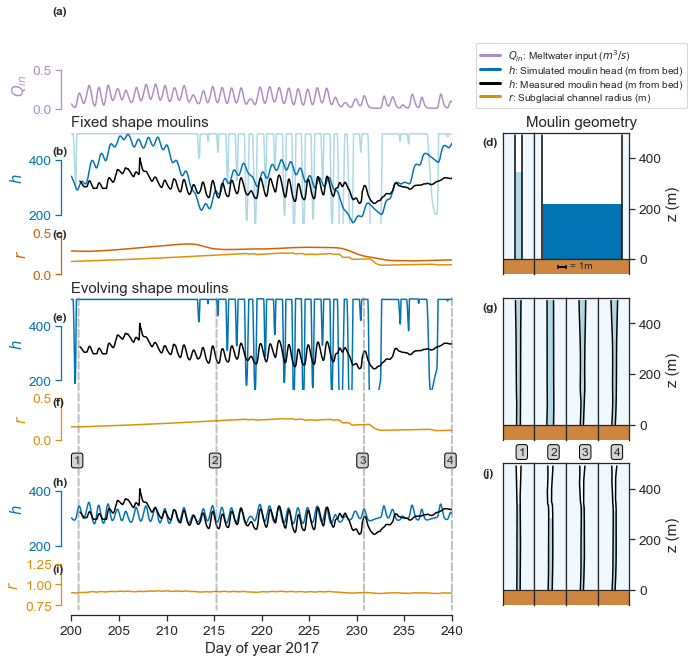

In [43]:

#sns.set()
sns.set_theme(style="ticks", font_scale=1.25)
palette=sns.color_palette("colorblind")


days = [200.75,215.25,230.75,240]

fig = plt.figure(figsize=(10,10))
#grid = plt.GridSpec(10,16,)
outer = gridspec.GridSpec(4, 2, height_ratios = [1,3,3,3], width_ratios=[3,1]) 
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec = outer[2])
gs4 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec = outer[3], wspace = 0)
gs5 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec = outer[4])
gs6 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec = outer[5], wspace = 0)
gs7 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec = outer[6])
gs8 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec = outer[7], wspace = 0)

ax1 = plt.subplot(gs1[0,0])
ax2a = plt.subplot(gs3[0:2, 0])#hw
ax2b = plt.subplot(gs3[2, 0])#Sub radius  
ax2c = plt.subplot(gs4[0, 0])#moulin1
ax2d = plt.subplot(gs4[0, 1:4])#moulin10

ax3a = plt.subplot(gs5[0:2, 0])#hw
ax3b = plt.subplot(gs5[2, 0])#Sub radius  
ax3c = plt.subplot(gs6[0, 0])#moulin1
ax3d = plt.subplot(gs6[0, 1])#moulin2
ax3e = plt.subplot(gs6[0, 2])#moulin3
ax3f = plt.subplot(gs6[0, 3])#moulin4

ax4a = plt.subplot(gs7[0:2, 0])#hw
ax4b = plt.subplot(gs7[2, 0])#Sub radius  
ax4c = plt.subplot(gs8[0, 0])#moulin1
ax4d = plt.subplot(gs8[0, 1])#moulin2
ax4e = plt.subplot(gs8[0, 2])#moulin3
ax4f = plt.subplot(gs8[0, 3])#moulin4



#Lines
height = 500
low = 0.7
color_line = 'grey'

fig.add_artist(ConnectionPatch(xyA=(days[0],height), coordsA=ax3a.transData,
                               xyB=(days[0],low), coordsB=ax4b.transData, 
                               arrowstyle="-",color=color_line,linewidth='2', linestyle='--', alpha=0.5))
fig.add_artist(ConnectionPatch(xyA=(days[1],height), coordsA=ax3a.transData,
                               xyB=(days[1],low), coordsB=ax4b.transData, 
                               arrowstyle="-",color=color_line,linewidth='2', linestyle='--', alpha=0.5))
fig.add_artist(ConnectionPatch(xyA=(days[2],height), coordsA=ax3a.transData,
                               xyB=(days[2],low), coordsB=ax4b.transData, 
                               arrowstyle="-",color=color_line,linewidth='2', linestyle='--', alpha=0.5))
fig.add_artist(ConnectionPatch(xyA=(days[3],height), coordsA=ax3a.transData,
                               xyB=(days[3],low), coordsB=ax4b.transData, 
                               arrowstyle="-",color=color_line,linewidth='2', linestyle='--', alpha=0.5))


#Qin
plot_timeserie(cylinder1,ax1,'meltwater_input_moulin',ylim=[0,0.6],color='#af8dc3', ylabel='$Q_{in}$')
#Head 1
plot_timeserie(cylinder1,ax2a,'head',ylim=[166,500],color='lightblue', ylabel='$h$')#palette[7])
plot_timeserie(cylinder10,ax2a,'head',ylim=[166,500],color=palette[0], ylabel='$h$')
sns.lineplot(x=h_doy,y=h_real,ax=ax2a,color='black')
ax2a.set_title('Fixed shape moulins', y=1.0,  loc='left') #pad=-15,
#Radius 1
plot_timeserie(cylinder1,ax2b,'subglacial_radius',ylim=[0,0.5],color=palette[1], ylabel='$r$')
#Radius 10
plot_timeserie(cylinder10,ax2b,'subglacial_radius',ylim=[0,0.5],color=palette[3], ylabel='$r$')
#Moulin 1
plot_moulin(cylinder1,ax2c,250,lim=2,yaxis=False, watercolor='lightblue')#palette[7])
#Moulin 10
plot_moulin(cylinder10,ax2d,250,lim=6, watercolor=palette[0])
ax2d.set_title('Moulin geometry')
ax2d.plot([-3,-2],[-30,-30],linestyle='-',linewidth=2,color='black')
ax2d.plot([-3,-3],[-25,-35],linestyle='-',linewidth=2,color='black')
ax2d.plot([-2,-2],[-25,-35],linestyle='-',linewidth=2,color='black')
ax2d.text(-1.5,-35,'= 1m', fontsize=10,)

#Head 2
plot_timeserie(bf0_fix,ax3a,'head',ylim=[166,500],color=palette[0], ylabel='$h$')
sns.lineplot(x=h_doy,y=h_real,ax=ax3a,color='black')
ax3a.set_title('Evolving shape moulins', loc='left')

#Radius 2 
plot_timeserie(bf0_fix,ax3b,'subglacial_radius',ylim=[0,0.5],color=palette[1], ylabel='$r$')
#Moulin 2
plot_moulin(bf0_fix,ax3c,days[0],lim=2,yaxis=False)
plot_moulin(bf0_fix,ax3d,days[1],lim=2,yaxis=False)
plot_moulin(bf0_fix,ax3e,days[2],lim=2,yaxis=False)
plot_moulin(bf0_fix,ax3f,days[3],lim=2,yaxis=True)
plot_number(ax3c,'1',0,-120)
plot_number(ax3d,'2',0,-120)
plot_number(ax3e,'3',0,-120)
plot_number(ax3f,'4',0,-120)

#Head 3
plot_timeserie(bf2_fix,ax4a,'head',ylim=[166,500],color=palette[0], ylabel='$h$')
sns.lineplot(x=h_doy,y=h_real,ax=ax4a,color='black')
#ax4a.set_title('Baseflow = 3 $m^3/s$', y=1.0, pad=-25, loc='Left')
#Radius 3
plot_timeserie(bf2_fix,ax4b,'subglacial_radius',ylim=[0.75,1.25],xlabel=True, color=palette[1], ylabel='$r$')
#Moulin 3
plot_moulin(bf2_fix,ax4c,days[0],lim=2,yaxis=False)
plot_moulin(bf2_fix,ax4d,days[1],lim=2,yaxis=False)
plot_moulin(bf2_fix,ax4e,days[2],lim=2,yaxis=False)
plot_moulin(bf2_fix,ax4f,days[3],lim=2,yaxis=True)

plot_number(ax4a,'1',days[0]-0.5,height)
plot_number(ax4a,'2',days[1]-0.5,height)
plot_number(ax4a,'3',days[2]-0.5,height)
plot_number(ax4a,'4',days[3]-0.5,height)

ax1.text(198,1.2,'(a)',fontsize=12, weight='bold')
ax2a.text(198,420,'(b)',fontsize=12, weight='bold')
ax2b.text(198,0.45,'(c)',fontsize=12, weight='bold')
ax2c.text(-4.5,450,'(d)',fontsize=12, weight='bold')
ax3a.text(198,420,'(e)',fontsize=12, weight='bold')
ax3b.text(198,0.42,'(f)',fontsize=12, weight='bold')
ax3c.text(-4.5,450,'(g)',fontsize=12, weight='bold')
ax4a.text(198,420,'(h)',fontsize=12, weight='bold')
ax4b.text(198,1.15,'(i)',fontsize=12, weight='bold')
ax4c.text(-4.5,450,'(j)',fontsize=12, weight='bold')



#legend

elements = [Line2D([0], [0], color='#af8dc3', lw=3, label='$Q_{in}$: Meltwater input ($m^3/s$)'),
            Line2D([0], [0], color=palette[0], lw=3, label='$h$: Simulated moulin head (m from bed)'),
            Line2D([0], [0], color='black', lw=3, label='$h$: Measured moulin head (m from bed)'),
            Line2D([0], [0], color=palette[1], lw=3, label='$r$: Subglacial channel radius (m)')]

elements_2 = [Line2D([0], [0], color='white',label='$cyl$ = fixed cylinder (r=5m)'),
              Line2D([0], [0], color='white',label='$b0$ = no baseflow'),
              Line2D([0], [0], color='white',label='$b3$ = baseflow = 3$m^3/s$')]

ax1.legend(handles=elements, loc=2, bbox_to_anchor=(1.05, 1.5), labelspacing=0,  prop={'size': 10})
#ax2c.legend(handles=elements_2, loc=2, bbox_to_anchor=(-0.5, 2), prop={'size': 10})


plt.savefig('Figure_TC/3sims.pdf',bbox_inches='tight')



(263.0, 316.0)

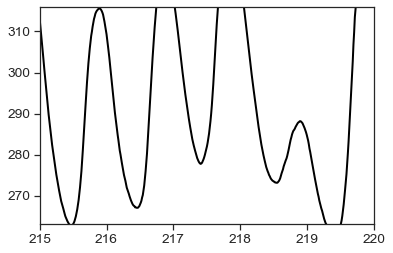

In [46]:
plt.figure()
plt.plot(h_doy,h_real, color='black',linewidth=lw)
plt.xlim([215,220])
plt.ylim([263,316])

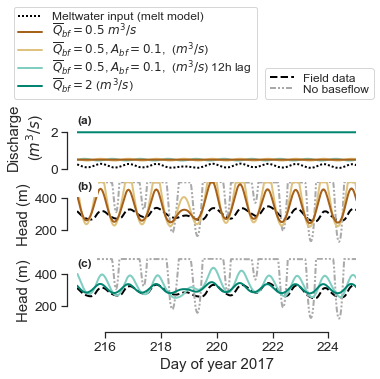

In [54]:
# CREATE COLOR PALETTE 
green_colorblind =  [0.00784313725490196, 0.6196078431372549, 0.45098039215686275]
#palette_lag = sns.color_palette('BuPu', n_colors=3) #RdBu PuOr
#palette_mean = sns.color_palette('YlOrBr', n_colors=1) #RdBu PuOr
palette = sns.cubehelix_palette(n_colors=10, start=1.5, rot=1, gamma=1.5, hue=1,
                                dark=0.2, light=0.9, reverse=True)

color= ['#a6611a','#dfc27d','#80cdc1','#018571']
#8c510a
#d8b365
#f6e8c3
#c7eae5
#5ab4ac
#01665e

# sns.palplot(palette_lag)
# sns.palplot(palette_mean)

xlim = [215,225] #days
ylim_head = [100,500]

size_legend = 12
lw = 2


#COMPARE LAG IN PEAK BASEFLOW
fig, ax = plt.subplots(3, figsize=(5,4))


ax[0].plot(bf1_osc_shift.time_day, bf1_osc_shift.dict['meltwater_input_moulin'], 
           label='Meltwater input (melt model)', color='black',linewidth=lw, linestyle=(0, (1, 1)))
ax[0].set_ylim([0.1,0.5])
ax[0].plot(bf1_fix.time_day, bf1_fix.dict['subglacial_baseflow'], 
           label='$\overline{Q}_{bf}=0.5$ $m^3/s$', color=color[0],linewidth=lw,zorder=3)#palette[5]
ax[0].plot(bf1_osc.time_day, bf1_osc.dict['subglacial_baseflow'], 
           label='$\overline{Q}_{bf}=0.5$, $A_{bf}=0.1$,  ($m^3/s$)',color=color[1],linewidth=lw)#
ax[0].plot(bf1_osc_shift.time_day, bf1_osc_shift.dict['subglacial_baseflow'], 
           label='$\overline{Q}_{bf}=0.5$, $A_{bf}=0.1$,  ($m^3/s$) 12h lag ', color=color[2],linewidth=lw,zorder=0)#palette[6]
ax[0].plot(bf2_fix.time_day, bf2_fix.dict['subglacial_baseflow'], 
           label='$\overline{Q}_{bf}=2$ ($m^3/s$)',color=color[3],linewidth=lw,zorder=0)#palette[8]


#plot preferences
ax[0].legend(loc=3, prop={'size': size_legend}, bbox_to_anchor=(-0.25, 1),labelspacing=0)
ax[0].set_xlim(xlim) 
ax[0].set_ylim([0,3.5]) 
ax[0].set_ylabel('Discharge\n($m^3/s$)')


#plot base head 
ax[1].plot(h_doy,h_real,label='Field data', color='black',linewidth=lw, linestyle='--')
ax[1].plot(bf0_fix.time_day, bf0_fix.dict['head'], label='No baseflow', color='darkgray',linewidth=lw, linestyle=(0, (3, 1, 1, 1, 1, 1)))
#plot head with lag
ax[1].plot(bf1_osc.time_day, bf1_osc.dict['head'], color=color[1],linewidth=lw)
ax[1].plot(bf1_fix.time_day, bf1_fix.dict['head'], color=color[0],linewidth=lw)
#ax[1].plot(bf1_osc_shift.time_day, bf1_osc_shift.dict['head'], color=palette[6],linewidth=lw)
#plot preferences
ax[1].legend(loc=3, prop={'size': size_legend},bbox_to_anchor=(0.65, 2.2),labelspacing=0)
ax[1].set_xlim(xlim) 
ax[1].set_ylim(ylim_head)
ax[1].set_ylabel('Head (m)')




#COMPARE mean BASEFLOW

#plot base head 
ax[2].plot(h_doy,h_real, color='black',linewidth=lw, linestyle='--')
ax[2].plot(bf0_fix.time_day, bf0_fix.dict['head'], color='darkgray',linewidth=lw, 
           linestyle=(0, (3, 1, 1, 1, 1, 1)))
#plot head with lag
ax[2].plot(bf1_osc_shift.time_day, bf1_osc_shift.dict['head'], color=color[2],linewidth=lw)
ax[2].plot(bf2_fix.time_day, bf2_fix.dict['head'], color=color[3],linewidth=lw)

#plot preferences
ax[2].set_xlim(xlim) 
ax[2].set_ylim(ylim_head)
ax[2].set_ylabel('Head (m)')
ax[2].set_xlabel('Day of year 2017')

#COMPARE baseflow and Qin

sns.despine(offset=10,trim=True)
sns.despine(ax=ax[0],bottom=True)
sns.despine(ax=ax[1],bottom=True)
ax[0].set_xticks([])
ax[1].set_xticks([])

#letters
ax[0].text(215,2.5,'(a)',fontsize=12, weight='bold', bbox=dict(facecolor='white', edgecolor='white'))
ax[1].text(215,450,'(b)',fontsize=12, weight='bold', bbox=dict(facecolor='white', edgecolor='white'))
ax[2].text(215,450,'(c)',fontsize=12, weight='bold', bbox=dict(facecolor='white', edgecolor='white'))




plt.savefig('Figure_TC/compare_bf_short.pdf',bbox_inches='tight')


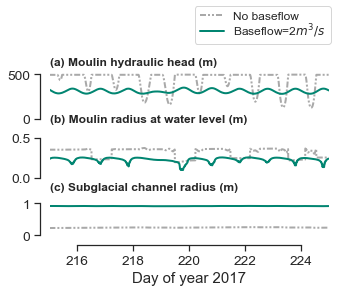

In [51]:
sns.set_theme(style="ticks", font_scale=1.25)
#palette = sns.cubehelix_palette(n_colors=4, start=1.5, rot=1, gamma=1.5, hue=1,
#                                dark=0.8, light=0.5, reverse=False)
    
lw =2
palette= ['#a6611a','#dfc27d','#80cdc1','#018571']

def extract_radius(moulin_sim):
    radius = np.zeros(len(moulin_sim.dict['head']))
    head_all = np.zeros(len(moulin_sim.dict['head']))
    for idx in np.arange(len(moulin_sim.dict['head'])):
        head = moulin_sim.dict['head'][idx]
        idx_position = find_nearest(moulin_sim.z,head)
        radius[idx] = moulin_sim.listdict[idx]['moulin_radius_minor'][idx_position]
        head_all[idx] = head
    return radius,head_all

radius_jeme_brut, head_brut = extract_radius(bf0_fix)
radius_jeme_bf2, head_bf2 = extract_radius(bf2_fix)

time_brut = np.array(bf0_fix.time_day)
time_bf2 = np.array(bf2_fix.time_day)

fig, axs = plt.subplots(3, sharex=False, figsize=(5,3))  

axs[0].plot(time_brut , head_brut, label= 'No baseflow', color='darkgray',linewidth=lw,linestyle=(0, (3, 1, 1, 1, 1, 1)))
axs[0].plot(time_bf2 , head_bf2, label= 'Baseflow=2$m^3/s$', color=palette[3],linewidth=lw)
axs[0].legend(loc=2, prop={'size': 12},bbox_to_anchor=(0.5,2.5), bbox_transform=axs[0].transAxes,labelspacing=0)
#axs[0].set_ylabel('(m)')
axs[0].set_xlim([215,225])

axs[1].plot(time_brut , radius_jeme_brut, label= 'No baseflow', color='darkgray',linewidth=lw,linestyle=(0, (3, 1, 1, 1, 1, 1)))
axs[1].plot(time_bf2 , radius_jeme_bf2, label= 'Baseflow=2$m^3/s$', color=palette[3],linewidth=lw)
#axs[1].set_ylabel('(m)')
axs[1].set_xlim([215,225])
axs[1].set_ylim([0,0.6])
#axs[1].legend(loc=1, prop={'size': 12},bbox_to_anchor=(1.1,0), bbox_transform=axs[1].transAxes,labelspacing=0)

#ax2 = axs[2].twinx()
axs[2].plot(time_brut , bf0_fix.dict['subglacial_radius'], label= 'No baseflow', color='darkgray',linewidth=lw,linestyle=(0, (3, 1, 1, 1, 1, 1)))
axs[2].plot(time_bf2 , bf2_fix.dict['subglacial_radius'], label= 'Baseflow=2$m^3/s$', color=palette[3],linewidth=lw)
#axs[2].legend(loc=1, prop={'size': 12},bbox_to_anchor=(1,0), bbox_transform=axs[1].transAxes,labelspacing=0)
#axs[2].set_ylabel('(m)', color=palette[0])
axs[2].set_ylim([0,1.5])
#ax2.set_ylim([1,1.11])
axs[2].set_xlim([215,225])
#ax2.set_ylabel('(m)', color=palette[2])
#axs[2].tick_params(axis='y', labelcolor=palette[0])
#axs[2].spines['left'].set_color(palette[0])
#ax2.tick_params(axis='y', color= palette[2], labelcolor=palette[2])
#ax2.spines['right'].set_color(palette[2])
axs[2].set_xlabel('Day of year 2017')

sns.despine(trim=True, offset=[10,10])

sns.despine(ax=axs[0],bottom=True)
sns.despine(ax=axs[1],bottom=True)
#sns.despine(ax=ax2,right=False)
axs[0].set_xticks([])
axs[1].set_xticks([])

#letters
axs[0].text(215,600,'(a) Moulin hydraulic head (m)',fontsize=12, weight='bold', bbox=dict(facecolor='white'))
axs[1].text(215,0.7,'(b) Moulin radius at water level (m)',fontsize=12, weight='bold', bbox=dict(facecolor='white'))
axs[2].text(215,1.4,'(c) Subglacial channel radius (m)',fontsize=12, weight='bold', bbox=dict(facecolor='white'))



plt.savefig('Figure_TC/radius_short.pdf',bbox_inches='tight')

